# Competing Against the Stopwatch: A Century of Olympic Speed


Swimming, as described by [Britannica](https://www.britannica.com/sports/swimming-sport), is the propulsion of the body through water by combined arm and leg motions and the natural flotation of the body. The sport has been a part of the Olympic stage since the inaugural modern Olympic Games held in 1896.

The purpose of this project is to analyze a century worth of Olympic swimming results and use that data to predict what time it will take to win a gold medal at the upcoming 2024 Paris Olympic Games in both the Men's and Women's 100m Freestyle events. For that we need to go over some of the basics of swimming to provide us with the tools to efficiently read the data.

Swimming Fundamentals:
- The competition is held in a 50 meter pool.
- The 8 fastest swimmers from the preliminaries (and semi-finals in some disciplines) advance to the final.
- At the conclusion of the finals, medals (Gold, Silver, and Bronze) are presented to the top 3 finishers.
- Ties can occur (even though it is rare).

### Hypothesis: It will take a sub-47 second swim on the men's side, and sub-52 second swim on the women's side to win a gold medal in Paris this summer in the 100m freestyle.

The goal of this project is to find a model that fits the data and use it to predict if the above hypothesis can be accepted. Before digging into the results of the 100m freestyle over time let's explore the dataset and prepare it for our analysis.

In [1]:
# Import necessary libraries and read the CSV into a dataframe to display the first 20 rows of the dataset.
import pandas as pd
import numpy as np
from IPython.display import display
from numpy import ones, linspace, floor, ceil
from sklearn.metrics import r2_score, mean_squared_error

df = pd.read_csv('Olympic_Swimming_Results_1912to2020.csv')
display(df.head(20))

print('\n')

df.info()

print('\nDataset is ready.')

,Location,Year,Distance (in meters),Stroke,Relay?,Gender,Team,Athlete,Results,Rank
0,Tokyo,2020,100m,Backstroke,0,Men,ROC,Evgeny Rylov,51.98,1
1,Tokyo,2020,100m,Backstroke,0,Men,ROC,Kliment Kolesnikov,52,2
2,Tokyo,2020,100m,Backstroke,0,Men,USA,Ryan Murphy,52.19,3
3,Tokyo,2020,100m,Backstroke,0,Men,ITA,Thomas Ceccon,52.3,4
4,Tokyo,2020,100m,Backstroke,0,Men,CHN,Jiayu Xu,52.51,4
5,Tokyo,2020,100m,Backstroke,0,Men,ESP,Hugo Gonzalez De Oliveira,52.78,4
6,Tokyo,2020,100m,Backstroke,0,Men,AUS,Mitchell Larkin,52.79,4
7,Tokyo,2020,100m,Backstroke,0,Men,ROU,Robert Glinta,52.95,4
8,Tokyo,2020,100m,Breaststroke,0,Men,GBR,Adam Peaty,57.37,1
9,Tokyo,2020,100m,Breaststroke,0,Men,NED,Arno Kamminga,58,2




<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4359 entries, 0 to 4358
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Location              4359 non-null   object
 1   Year                  4359 non-null   int64 
 2   Distance (in meters)  4359 non-null   object
 3   Stroke                4359 non-null   object
 4   Relay?                4359 non-null   int64 
 5   Gender                4359 non-null   object
 6   Team                  4359 non-null   object
 7   Athlete               4345 non-null   object
 8   Results               4331 non-null   object
 9   Rank                  4359 non-null   int64 
dtypes: int64(3), object(7)
memory usage: 340.7+ KB

Dataset is ready.


We can see that the data is relatively clean but there are some modifications we need to make before moving on with our analysis. It appears that the dataset is in chronological order and includes the results of the finals only, which substantially reduces to amount of rows we need to process as we will be looking at the top 8 swimmers in each event instead of the full number of participants.

Adjustments required:
1. We will be looking at individual 100m freestyle winners only. To do that, we will need to filter the dataset to include rows where the Distance is 100m, the Stroke is Freestyle, and the Rank is 1.
2. Since we will perform an analysis for both genders we will need to break the dataframe out into 2 dataframes.
3. There are some unneccessary columns that will be deleted.
4. We will change the 'Results' column's data type to display seconds and hundreds of seconds for which we will use floats. Disqualifications do happen, so we might need to account for that. If there are duplicates, we will need to remove those.

Before making these changes to our data, for fun, let's return the most decorated male and female Olympic champions (based on individual races) first!

In [2]:
# Most decorated Olympians
from collections import Counter

win_men = df[(df['Rank'] == 1) & (df['Relay?'] == 0) & (df['Gender'] == 'Men')]['Athlete'].tolist()
counts_men = Counter(win_men)
most_decorated_man = [key for key, value in counts_men.items() if value == max(counts_men.values())]

win_women = df[(df['Rank'] == 1) & (df['Relay?'] == 0) & (df['Gender'] == 'Women')]['Athlete'].tolist()
counts_women = Counter(win_women)
most_decorated_woman = [key for key, value in counts_women.items() if value == max(counts_women.values())]

print((most_decorated_man[0], most_decorated_woman[0]))

('Michael Phelps', 'Katie Ledecky')


The most decorated Olympians are Michael Phelps and Katie Ledecky, both from the USA. Interesting fact: Katie is still active and is looking to defend her titles in Paris this summer, so if you enjoy watching generational talents on television it will be worth to tune in for the swimming events since this might be her last competition.

In [3]:
#1: Returning the dataset filtered down to the winners of the 100m freestyle only. This should return less rows than our original dataframe.

free_champs = df[(df['Distance (in meters)'] == '100m') & (df['Stroke'] == 'Freestyle') & (df['Rank'] == 1)].copy()
free_champs.reset_index(inplace=True, drop=True)
assert len(free_champs) < len(df), "Returned dataframe's rows should be less than the original dataframe's rows."

display(free_champs.head())

,Location,Year,Distance (in meters),Stroke,Relay?,Gender,Team,Athlete,Results,Rank
0,Tokyo,2020,100m,Freestyle,0,Men,USA,Caeleb Dressel,47.02,1
1,Tokyo,2020,100m,Freestyle,0,Women,AUS,Emma Mckeon,51.96,1
2,Rio,2016,100m,Freestyle,0,Men,AUS,Kyle Chalmers,47.580,1
3,Rio,2016,100m,Freestyle,0,Women,USA,Simone Manuel,52.700,1
4,Rio,2016,100m,Freestyle,0,Women,CAN,Penny Oleksiak,52.700,1


In [4]:
#2: Break dataframe out into 2 dataframes (1 for each gender)

men = free_champs[free_champs['Gender'] == 'Men']
women = free_champs[free_champs['Gender'] == 'Women']

display(men.head())
display(women.head())

,Location,Year,Distance (in meters),Stroke,Relay?,Gender,Team,Athlete,Results,Rank
0,Tokyo,2020,100m,Freestyle,0,Men,USA,Caeleb Dressel,47.02,1
2,Rio,2016,100m,Freestyle,0,Men,AUS,Kyle Chalmers,47.580,1
5,London,2012,100m,Freestyle,0,Men,USA,Nathan Adrian,47.520,1
7,Beijing,2008,100m,Freestyle,0,Men,FRA,Alain Bernard,47.210,1
9,Athens,2004,100m,Freestyle,0,Men,NED,Pieter Van Den Hoogenband,48.170,1


,Location,Year,Distance (in meters),Stroke,Relay?,Gender,Team,Athlete,Results,Rank
1,Tokyo,2020,100m,Freestyle,0,Women,AUS,Emma Mckeon,51.96,1
3,Rio,2016,100m,Freestyle,0,Women,USA,Simone Manuel,52.700,1
4,Rio,2016,100m,Freestyle,0,Women,CAN,Penny Oleksiak,52.700,1
6,London,2012,100m,Freestyle,0,Women,NED,Ranomi Kromowidjojo,53.000,1
8,Beijing,2008,100m,Freestyle,0,Women,GER,Britta Steffen,53.120,1


In [5]:
#3: Delete unneccessary columns. We will only really need 'Year' and 'Results'

keep_cols = ['Year', 'Results']
men = men[keep_cols].reset_index(drop=True)
women = women[keep_cols].reset_index(drop=True)

display(men.head())
display(women.head())

,Year,Results
0,2020,47.02
1,2016,47.580
2,2012,47.520
3,2008,47.210
4,2004,48.170


,Year,Results
0,2020,51.96
1,2016,52.700
2,2016,52.700
3,2012,53.000
4,2008,53.120


In [6]:
#4: Change the Results column to display seconds and hundreds of seconds only. This will be a little challenging.

# Let's see the unique values first combined in one list.
times1 = list(men['Results'])
times2 = list(women['Results'])
all_times = times1 + times2
print(all_times)

# We can see that the values are not in the same format and length, so let's create a function that returns the appropriate format.
def time_formatter(time):
    if type(time) == float:
        return time
    elif len(time) == 5 or len(time) == 6:
        return float(time)
    else:
        minutes = int(time[3:5])
        seconds = int(time[6:8])
        hundreds = float(time[8:11])
        return minutes*60 + seconds + hundreds

#Now apply the function to the dataframes
men['Results'] = men['Results'].apply(time_formatter)
women['Results'] = women['Results'].apply(time_formatter)

#Remove duplicates from both dataframes
men.drop_duplicates(subset=['Year', 'Results'], keep='first', inplace=True)
women.drop_duplicates(subset=['Year', 'Results'], keep='first', inplace=True)

['47.02', '47.580', '47.520', '47.210', '48.170', '48.300', '48.740', '49.020', '48.630', '49.800', '50.400', '49.990', '51.220', '52.200', '53.400', '55.100', '55.400', '57.400', '57.400', '00:01:00.500000', '57.600', '58.200', '00:01:00.000000', '00:01:01.400000', '00:01:01.400000', '00:01:03.400000', '51.96', '52.700', '52.700', '53.000', '53.120', '53.840', '53.830', '54.500', '54.640', '54.930', '55.920', '55.920', '54.790', '55.650', '00:01:00.020000', '00:01:00.000000', '00:01:00.800000', '00:01:01.200000', '00:01:02.000000', '00:01:06.800000', '00:01:06.300000', '00:01:05.900000', '00:01:06.800000', '00:01:11.000000', '00:01:12.400000', '00:01:22.200000']


In [7]:
men.head()

,Year,Results
0,2020,47.02
1,2016,47.58
2,2012,47.52
3,2008,47.21
4,2004,48.17


In [8]:
women.head()

,Year,Results
0,2020,51.96
1,2016,52.70
3,2012,53.00
4,2008,53.12
5,2004,53.84


### Visualizations and  Finding a Model to Fit

Visualizing the data will help us identify common patterns and trends. Given the rapid development around sports over the past few decades and the continuous improvements in performance, it is safe to expect a linear relationship between the predictor and response (x- and y-axis). Once the data is visualized, it will be easier to confirm whether a linear regression model (univariate in this case) can be of any use for predicting the results of the 2024 Olympics or not.  

Text(0.5, 1.0, 'Olympic Champion Times Men 1912 - 2020')

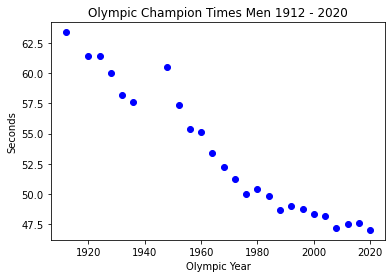

In [9]:
#Let's do a visualization of the results for men first

from matplotlib.pyplot import scatter, xlabel, ylabel, title, plot
%matplotlib inline

scatter(men['Year'], men['Results'], c='blue')
xlabel ('Olympic Year')
ylabel('Seconds')
title ('Olympic Champion Times Men 1912 - 2020')

Text(0.5, 1.0, 'Olympic Champion Times Women 1912 - 2020')

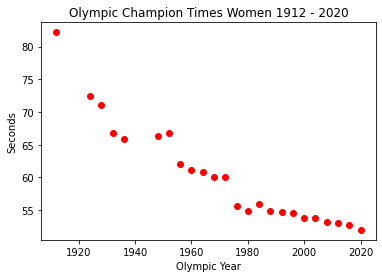

In [10]:
#Now let's visualize the results of women

scatter(women['Year'], women['Results'], c='red')
xlabel ('Olympic Year')
ylabel('Seconds')
title ('Olympic Champion Times Women 1912 - 2020')

The scatter plots confirm our expectations: over the years, advancements in technology, nutrition, recovery, training methods, and mental health services have contributed to a consistent improvement in the winning times for the 100m freestyle (and other disciplines) at the Olympics. Thus, using a univariate linear regression model can assist us in predicting the performance required to secure a gold medal in the 100m freestyle event at the 2024 Olympic Games for both men and women.

### Finding Alpha and Beta for the Univariate Model

To compute $\alpha$ and $\beta$ for the univariate model, $y \sim \alpha \cdot x + \beta$, we will need to turn the 'Year' and 'Results' columns into Numpy Arrays. Our function will take the predictors (x) and the dependent variables (y), or responses, and return a tuple containing alpha and beta ($\alpha$, $\beta$).

According to the lecture videos on Linear Regression, $\alpha$ and $\beta$ can be computed using the following formulas.

$$\begin{eqnarray}
  \alpha & = & \dfrac{x^T y - \frac{1}{m}(u^T x)(u^T y)}
                     {x^T x - \frac{1}{m}(u^T x)^2} \\
   \beta & = & \frac{1}{m} u^T (y - \alpha x)
\end{eqnarray}$$

In this formula, $u$ is a dummy vector of ones that we use in most of the regressions we have covered this semester.

In [11]:
# Turning the columns into Numpy arrays and storing them in variables.

x_men = men['Year'].to_numpy()
y_men = men['Results'].to_numpy()
x_women = women['Year'].to_numpy()
y_women = women['Results'].to_numpy()

# Constructing a function to return alpha and beta

def alpha_and_beta(x, y):
    m = len(x) ; assert len(y) == m
    u = ones(m)
    alpha = x.T.dot(y) - (u.T.dot(x) * u.T.dot(y)) / m
    alpha /= x.T.dot(x) - (u.T.dot(x))**2 / m
    beta = u.T.dot((y - alpha * x)) / m
    return (alpha, beta)

# Compute alpha and beta for both men and women

alpha_m, beta_m = alpha_and_beta(x_men, y_men)
alpha_w, beta_w = alpha_and_beta(x_women, y_women)

print("Alpha & Beta for Men:", (alpha_m, beta_m))
print("Alpha & Beta for Women:", (alpha_w, beta_w))

Alpha & Beta for Men: (-0.15999593454617292, 368.36319138119694)
Alpha & Beta for Women: (-0.2332082152974562, 520.0657672332502)


### Constructing the Best-Fit Linear Model Using the Variables from the Previous Step

Text(0.5, 1.0, 'Olympic Champion Times Men 1912 - 2020')

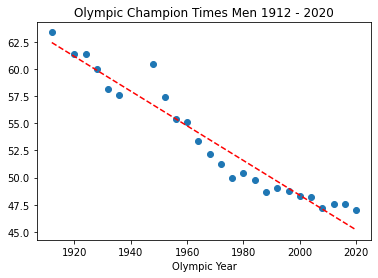

In [12]:
# Best fit linear model for men.

x_fit_m = linspace(floor(x_men.min()), ceil(x_men.max()), 2)
y_fit_m = alpha_m*x_fit_m + beta_m

scatter(x_men, y_men, marker='o')
plot(x_fit_m, y_fit_m, 'r--')
xlabel('Olympic Year')
title('Olympic Champion Times Men 1912 - 2020')

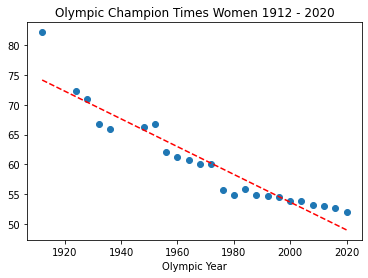

In [13]:
# Best fit linear model for women.

x_fit_w = linspace(floor(x_women.min()), ceil(x_women.max()), 2)
y_fit_w = alpha_w*x_fit_w + beta_w

scatter(x_women, y_women, marker='o')
plot(x_fit_w, y_fit_w, 'r--')
xlabel('Olympic Year')
title('Olympic Champion Times Women 1912 - 2020');

It appears that these are likely the best-fit linear models for our analysis purpose. Looking at the scatterplots we can identify a few interesting patterns. First, the affect of the World Wars on the Olympic Games. In 1916, 1940, and 1944, the Olympic Games got canceled. There was a significant improvement in winning times between 1912 and 1920, while little to no improvements between 1936 and 1948. The Cold War Era, where (unfortunately) certain countries experimented on their athletes by launching state-sponsored, systematic doping programs lead to drastic improvements in winning times that explains why most entries between the 60s and the 2000s are below the line. More on doping [here](https://en.wikipedia.org/wiki/Doping_in_East_Germany). The establishment of WADA, World Anti-Doping Agency, in 1999 led to strict enforcement of doping regulations, which can explain why the improvement in winning times for the past few Olympics slowed down leading to the entries appearing above the line. Also, athletes are likely encountering the peak of human performance leading to a more flat linear pattern for the upcoming years.

### Confirming if Model is Good Fit

We will compute the R-squared ($R^2$) and Mean Squared Error (MSE) to evaluate the performance of this regression model. 
- R-squared error measures the percentage variation in the dependent variable that is accounted for by the independent variable in the model. The results range from 0 to 1, where 0 means that the model does not explain any of the variance and 1 means that the model explains all the variance, thus being a perfect fit for the data.
- MSE computes the average squared difference between the observations and predictions. Lower values indicate better model predictions with 0 being the perfect prediction.

In [14]:
# Add Results_P column to both dataframes that are the predicitons based on our model and assign them to variables.

men['Results_P'] = alpha_m* men['Year'] + beta_m
women['Results_P'] = alpha_w*women['Year'] + beta_w
y_men_pred = men['Results_P'].to_numpy()
y_women_pred = women['Results_P'].to_numpy()

# Return the R-squared and MSE results as a dataframe to draw conclusions.
R_squared_error_men = r2_score(y_men, y_men_pred)
MSE_men = mean_squared_error(y_men, y_men_pred)

R_squared_error_women = r2_score(y_women, y_women_pred)
MSE_women = mean_squared_error(y_women, y_women_pred)

errors = {'Men': [R_squared_error_men, MSE_men], 'Women': [R_squared_error_women, MSE_women]}
errors_df = pd.DataFrame(errors, index=['R-Squared Error', 'MSE'])
errors_df

,Men,Women
R-Squared Error,0.936307,0.891927
MSE,1.754451,6.203244


Even though the R-Squared Error results are promising, the MSE for women implies that the model might not be the perfect fit for which we will get the answers when comparing the predicted winning times for 2024 with the current world records in the 100m freestyle. 

### Predicting the Winning Times for 2024

To predict the winning times for the 2024 Paris Olympic Games we will use $\alpha$ and $\beta$ from the previous steps and decide if we can accept the hypothesis and confirm that the model generates realistic results, thus being a good fit for our data. The current world records will be a good comparison to show us how realistic these predictions are. According to [Wikipedia](https://en.wikipedia.org/wiki/List_of_world_records_in_swimming), the current world records are:
- Men: Pan Zhanle (China) - 46.80 seconds
- Women: Sarah Sjöström (Sweden) - 51.71 seconds

In [15]:
# Winning time prediction for men and women

men_winning_time = alpha_m*2024 + beta_m
women_winning_time = alpha_w*2024 + beta_w

print("Predicted Winning Time Men:", round((men_winning_time), 2), "seconds")
print("Predicted Winning Time Women:", round((women_winning_time), 2), "seconds")

Predicted Winning Time Men: 44.53 seconds
Predicted Winning Time Women: 48.05 seconds


### Conclusion

The hypothesis can be accepted as the the predicted winning times for men and women are faster than 47 seconds and 52 seconds, respectively. However, the Mean Squared Error (MSE) is relatively high for women, which can mean two things: the model is not a good fit, or there are outliers that skew the results. 

My considerations are as follows:
1. The predicted times are significantly faster than the current world records, which makes this analysis irrealistic.
2. Most, if not all, outliers are from eras when external factors deeply affected outcomes. (wars, mass doping scandals, etc.)
3. Sports only got commercialized a few decades ago. It was a luxury in earlier eras. (significantly less participants)
4. Linear regression is a good fit to predict swimming outcomes but the data is insufficient for our goals.

A better approach would be:
- Analyze world ranking data for every year (I could not find this in an ingestable format).
- Select a cutoff date that is after the times when outliers occurred. (Post-War Era)
- Account for all possible external factors.
- Compare results with other sports.
- Consider gender disparities in performance trends.
- Minimize bias by collaborative data review and analysis.